In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import RBFSampler

In [2]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [3]:
# load embeddings
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
irmas/yamnet
irmas/yamnet/features
irmas/yamnet/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys
openmic/yamnet
openmic/yamnet/features
openmic/yamnet/keys


# OpenL3

In [4]:
embedding_name = 'openl3'

## load embedding

In [5]:
#########################
# irmas: openl3 embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(167625, 512) (167625,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [6]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [7]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [8]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [9]:
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 512) (5039,)


In [10]:
#########################
# openmic: openl3 embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(1900000, 512) (1900000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [11]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [12]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [13]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## kernelize & LDA

In [14]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
Sampler.best_estimator_

RBFSampler(gamma=1e-05, n_components=2048, random_state=0)

In [15]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [16]:
with open('kernelize_LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

In [17]:
colors = ['#0271AE', '#DC2830']
dataset_name = ['IRMAS', 'OpenMIC']

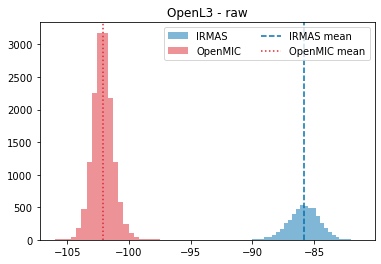

In [18]:
FEATURES = 'OpenL3'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

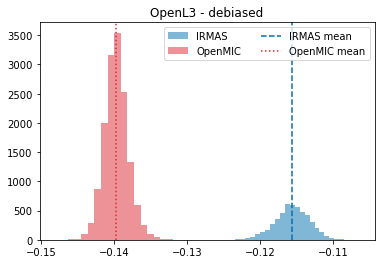

In [19]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

# VGGish

In [20]:
embedding_name = 'vggish'

## Load embedding

In [21]:
#########################
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(13410, 128) (13410,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 128) (6705,)


In [22]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [23]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [24]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [25]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 128) (5039,)


In [26]:
#########################
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(180000, 128) (180000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [27]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [28]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [29]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## kernelize & LDA

In [30]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
Sampler.best_estimator_

RBFSampler(gamma=1e-05, n_components=512, random_state=0)

In [31]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [32]:
with open('kernelize_LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

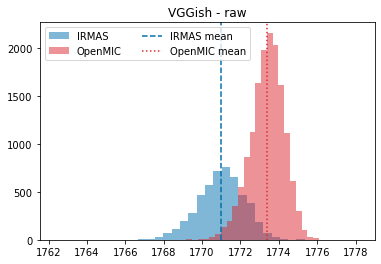

In [33]:
FEATURES = 'VGGish'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

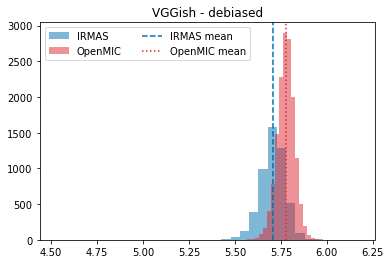

In [34]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

# YAMnet

In [35]:
embedding_name = 'yamnet'

## Load embedding

In [36]:
#########################
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(33525, 1024) (33525,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [37]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [38]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [39]:
keys = [key[key.index('[')+1:key.index(']')] for key in key_clip]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [40]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
Y_ir = np.zeros(len(X_train))

print(X_train.shape, Y_ir.shape)

(5039, 1024) (5039,)


In [41]:
#########################
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

X = []

for key in tqdm(key_clip):
    X.append(np.mean(feature[keys[:]==key,:],axis=0))
    
X = np.array(X)
print(X.shape, key_clip.shape)

key_clip = np.array(key_clip)
key_clip

(380000, 1024) (380000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [42]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [43]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [44]:
X_train = np.vstack((X_train, X[idx_train]))

Y_om = np.ones(len(X[idx_train]))
Y = np.hstack((Y_ir, Y_om))

## kernelize & LDA

In [45]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
Sampler.best_estimator_

RBFSampler(gamma=1e-05, n_components=4096, random_state=0)

In [46]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X_train, Y)

v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

Xdeb = X_train.dot(np.eye(len(A)) - A)
Xsproj = LDA.transform(X_train)
Xdproj = LDA.transform(Xdeb)

In [47]:
with open('kernelize_LDA_' + embedding_name + '_coef.pickle', 'wb') as fdesc:
    pickle.dump(LDA.coef_, fdesc)

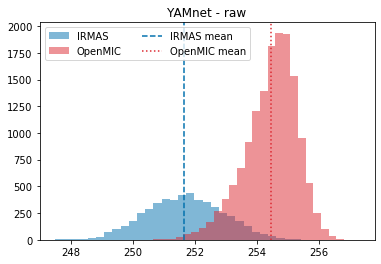

In [48]:
FEATURES = 'YAMnet'
plt.title(f'{FEATURES} - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)

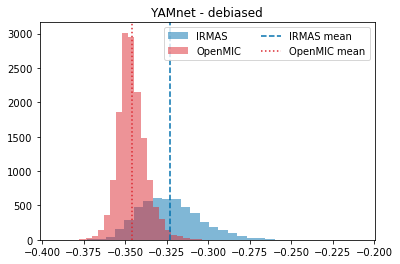

In [49]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
plt.legend(ncol=2)